# Notebook about Motor Vehicle Collisions in New York City

In [1]:
import pandas as pd
import time
import numpy as np
import calendar
import plotly.express as px

t1 = time.time()
df = pd.read_csv('preprocessed_collisions.csv')
df['TIME'] = df['CRASH DATE'] + ' ' + df['CRASH TIME']
df['TIME'] = pd.to_datetime(df['TIME'], format="%m/%d/%Y %H:%M")
t2 = time.time()

#Discard 2012 and 2021. 
df = df.loc[(df['TIME'].dt.year > 2012) & (df['TIME'].dt.year < 2021)]

print(f'Time elapsed: {t2-t1} seconds.')

Time elapsed: 23.577653646469116 seconds.


# Probability of being injured or killed

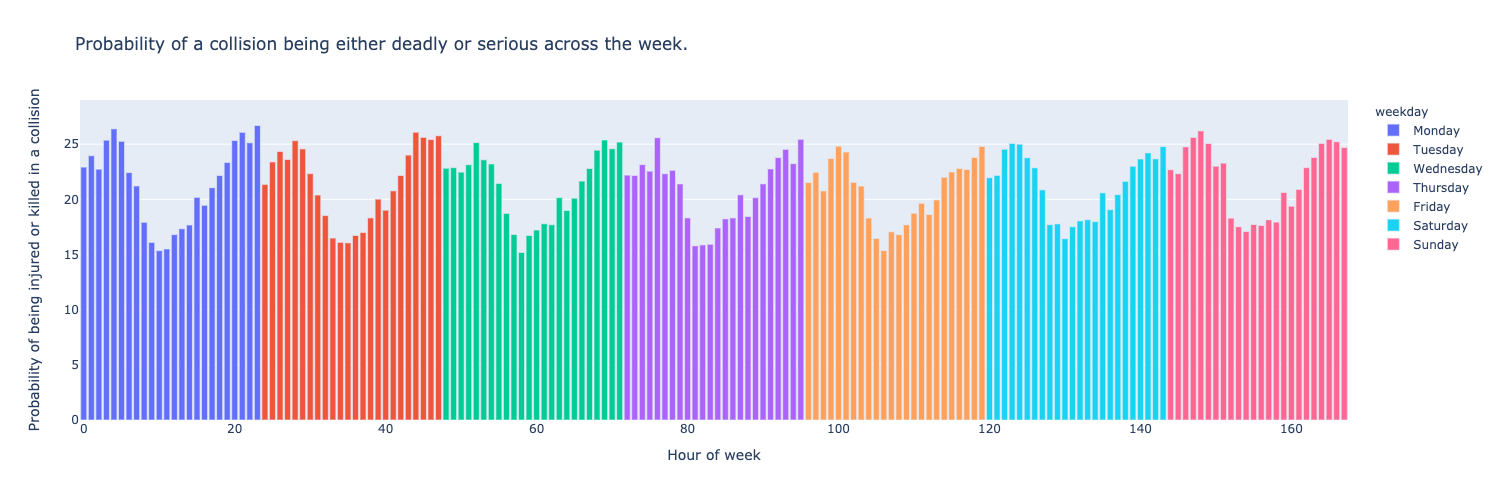

In [3]:
df['AnyInjured'] = (df['NUMBER OF PERSONS INJURED'] > 0).astype(int)
df['AnyKilled']  = (df['NUMBER OF PERSONS KILLED'] > 0).astype(int)

df_plot1 = pd.DataFrame({'hour_of_week'          : np.arange(0,24*7),
                         'only_injured'  : df.loc[(df['AnyInjured'] == 1)&(df['AnyKilled'] == 0)].groupby([df['TIME'].dt.hour, df['TIME'].dt.weekday]).size().unstack().fillna(0).values.reshape(-1,order='F').astype(int),
                         'only_killed'   : df.loc[(df['AnyInjured'] == 0)&(df['AnyKilled'] == 1)].groupby([df['TIME'].dt.hour, df['TIME'].dt.weekday]).size().unstack().fillna(0).values.reshape(-1,order='F').astype(int),
                         'both'          : df.loc[(df['AnyInjured'] == 1)&(df['AnyKilled'] == 1)].groupby([df['TIME'].dt.hour, df['TIME'].dt.weekday]).size().unstack().fillna(0).values.reshape(-1,order='F').astype(int),
                         'either'        : df.loc[(df['AnyInjured'] == 1)|(df['AnyKilled'] == 1)].groupby([df['TIME'].dt.hour, df['TIME'].dt.weekday]).size().unstack().fillna(0).values.reshape(-1,order='F').astype(int),
                         'total_count'   : df.groupby([df['TIME'].dt.hour, df['TIME'].dt.weekday]).size().unstack().values.reshape(-1,order='F'),
                         'weekday'       : np.repeat(list(calendar.day_name),24)})

df_plot1['probability'] = (df_plot1['either']/df_plot1['total_count'])*100
df_plot1['weekday_and_time'] = df_plot1['weekday'] + ' ' + [str(x).zfill(2)+':00' for x in np.arange(0,24)]*7

fig = px.bar(df_plot1,x='hour_of_week', y='probability',
             custom_data=['only_injured', 'only_killed', 'both', 'total_count', 'weekday_and_time'],
             labels = {'hour_of_week' : 'Hour of week', 'probability' : 'Probability of being injured or killed in a collision'},
             color='weekday',
             title='Probability of a collision being either deadly or serious across the week.',
             height=500, width=1500)


fig.update_traces(
    hovertemplate="<br>".join([
        "<b>%{customdata[4]}</b>",
        "",
        "Number of collisions with only injured: %{customdata[0]}",
        "Number of collisions with only killed: %{customdata[1]}",
        "Number of collisions with both killed and injured: %{customdata[2]}",
        "Total number of collisions: %{customdata[3]}",
        "",
        "Probability of a collision being serious: %{y}%",
    ])
)

fig.update_layout(yaxis_range=[0,np.ceil(df_plot1['probability'].max())+2])
fig.show()

In [4]:
import numpy as np
factors = df[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]].values.reshape(-1,)
factors = np.unique(factors[~pd.isna(factors)])

In [5]:
mask = np.zeros(len(df))
contributing_factors = df[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]].values
for factor in factors:
    for i in range(len(df)):
        if factor in contributing_factors[i,:]:
            mask[i] = 1
            
    df_subset = df.iloc[mask.astype(bool),:]
    
    p = len(df_subset.loc[(df_subset['NUMBER OF PERSONS KILLED'] + df_subset['NUMBER OF PERSONS INJURED']) > 0]) / len(df_subset)
    print(f'{factor} : {p}')

1 : 0.14285714285714285
80 : 0.136986301369863
Accelerator Defective : 0.288135593220339
Aggressive Driving/Road Rage : 0.28818710359408034
Alcohol Involvement : 0.29566896309623064
Animals Action : 0.2886610878661088
Backing Unsafely : 0.14462648048297155
Brakes Defective : 0.15287437899219306
Cell Phone (hand-Held) : 0.15359022311138174
Cell Phone (hand-held) : 0.1536564431841639
Cell Phone (hands-free) : 0.15373943203988727
Driver Inattention/Distraction : 0.2005224172523881
Driver Inexperience : 0.1993662044145988
Driverless/Runaway Vehicle : 0.19925698925756116
Drugs (Illegal) : 0.1993575869269654


KeyboardInterrupt: 

## Cleaning up the data

In [6]:
df_serious = df.loc[(df['NUMBER OF PERSONS KILLED'] + df['NUMBER OF PERSONS INJURED']) > 0]
df_serious['TIME'] = pd.to_datetime(df_serious['CRASH DATE'] + ' ' + df_serious['CRASH TIME']) #Takes approximately 1 minute.

#Discard 2012 and 2021.
df_serious = df_serious.loc[~((df_serious['TIME'].dt.year == 2012) | (df_serious['TIME'].dt.year == 2021))]


#Drop rows with NA in BOROUGH, ZIP CODE, LATITUDE or LONGITUDE.
#col = ['BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE']
#for c in col:
#    df_serious = df_serious.loc[~pd.isna(df_serious[c])]
#    
#Drop rows where LAT, LON == 0.000
#df_serious = df_serious.loc[~(df_serious['LATITUDE'] == 0)]
#df_serious = df_serious.loc[~(df_serious['LONGITUDE'] == 0)]

/Users/Marie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Print the first observations.

In [8]:
pd.set_option('display.max_columns', None)
df_serious.head()

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,CONTRIBUTING FACTORS (SPECIFIC),CONTRIBUTING FACTORS (GENERAL),VEHICLE TYPES,TIME,AnyInjured,AnyKilled
64,243,12/05/2020,13:45,BROOKLYN,11234,40.651863,-73.865360,"(40.651863, -73.86536)",BELT PARKWAY,NaN,NaN,1.0,0.0,0,0,0,0,1,0,Following Too Closely,Unspecified,Unspecified,NaN,NaN,4373337,Sedan,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,Following Too Closely,Poor Driving,"Car, Car, Car",2020-12-05 13:45:00,1,0
69,262,11/24/2020,8:40,BROOKLYN,11201,40.688572,-73.991104,"(40.688572, -73.991104)",PACIFIC STREET,NaN,NaN,1.0,0.0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4370719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-24 08:40:00,1,0
72,266,11/21/2020,17:00,BROOKLYN,11235,40.575726,-73.961150,"(40.575726, -73.96115)",NaN,NaN,3152 BRIGHTON 6 STREET,1.0,0.0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4369527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-21 17:00:00,1,0
73,269,11/20/2020,12:40,BROOKLYN,11211,40.715400,-73.926930,"(40.7154, -73.92693)",GARDNER AVENUE,GRAND STREET,NaN,1.0,0.0,0,0,0,0,1,0,Pavement Defective,NaN,NaN,NaN,NaN,4369463,Motorcycle,NaN,NaN,NaN,NaN,Pavement Defective,Physical Surroundings,Motorcycle,2020-11-20 12:40:00,1,0
75,279,11/18/2020,13:50,QUEENS,11373,40.737490,-73.877280,"(40.73749, -73.87728)",NaN,NaN,86-34 BROADWAY,1.0,0.0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4368838,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,Car,2020-11-18 13:50:00,1,0


In [ ]:
# Make dataframe only where contributing factor is drunk driving
df_serious_alco =  df_serious[(df_serious['CONTRIBUTING FACTOR VEHICLE 1'] == "Alcohol Involvement")]
#df_alco =  df[(df['CONTRIBUTING FACTOR VEHICLE 1'] == "Alcohol Involvement")]

In [130]:
df_alco = df.loc[df[[f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1,6)]].astype(str).apply(lambda x : 'Alcohol Involvement' in list(x), axis=1)]

In [119]:
df_serious_alco['YEAR'] = df_serious_alco['TIME'].dt.year
df_serious_alco['MONTH'] = df_serious_alco['TIME'].dt.month

df_alco['YEAR'] = df_alco['TIME'].dt.year
df_alco['MONTH'] = df_alco['TIME'].dt.month

/Users/Marie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Marie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Marie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

## How has the number of collisions with alcohol involment changed?

All you need to do is subtract your current year earnings by last year's earnings, then divide by last year's earnings. Then, you multiply the resulting figure by 100, which provides you with a percentage figure.

In [49]:
df_serious_alco.groupby('YEAR')['NUMBER OF PERSONS INJURED'].sum()

YEAR
2013     566.0
2014     616.0
2015     618.0
2016     989.0
2017    1199.0
2018     989.0
2019     966.0
2020     724.0
Name: NUMBER OF PERSONS INJURED, dtype: float64

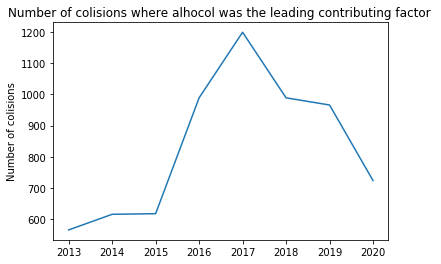

In [51]:
import matplotlib.pyplot as plt
plt.plot(df_serious_alco.groupby('YEAR')['NUMBER OF PERSONS INJURED'].sum())
plt.title("Number of colisions where alhocol was the leading contributing factor ")
plt.ylabel("Number of colisions")
plt.show()

In [127]:
pd.pivot_table(df_alco,index=['YEAR','MONTH'],values = ['NUMBER OF PERSONS INJURED'], aggfunc=np.sum).astype(int)

NUMBER OF PERSONS INJURED
YEAR MONTH                           
2013 1                             45
     2                             36
     3                             32
     4                             52
     5                             58
...                               ...
2020 8                             51
     9                             89
     10                            79
     11                            43
     12                            52

[96 rows x 1 columns]

## Where is the highest probabilty of being injured or die

In [ ]:
import plotly.express as px
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/fedhere/PUI2015_EC/master/mam1612_EC/nyc-zip-code-tabulation-areas-polygons.geojson') as response:
    counties = json.load(response)

In [112]:
zip_and_borough = []
for feature in counties['features']:
    zip_and_borough.append([feature['properties']['borough'], feature['properties']['postalCode']])
    
zip_and_borough = pd.DataFrame(zip_and_borough, columns=['Borough', 'ZIP CODE'])
zip_and_borough['ZIP CODE'] = zip_and_borough['ZIP CODE'].astype(int)
zip_and_borough

,Borough,ZIP CODE
0,Queens,11372
1,Queens,11004
2,Queens,11040
3,Queens,11426
4,Queens,11365
...,...,...
257,Manhattan,10065
258,Manhattan,10075
259,Manhattan,10069
260,Manhattan,10281


In [113]:
df_temp1 = pd.DataFrame(df_alco.loc[(df_alco['ZIP CODE']) != 0].groupby('ZIP CODE').size().reset_index()); df_temp1.columns = ['ZIP CODE', 'TOTAL COUNT']
df_temp1['ZIP CODE'] = df_temp1['ZIP CODE'].astype(int)
df_temp1

,ZIP CODE,TOTAL COUNT
0,10001,72
1,10002,145
2,10003,45
3,10004,19
4,10005,3
...,...,...
177,11691,80
178,11692,17
179,11693,30
180,11694,40


In [114]:
df_temp2 = pd.DataFrame(df_alco.loc[(df_alco['ZIP CODE']) != 0].loc[(df_alco['AnyInjured']|df_alco['AnyKilled']).astype(bool)].groupby('ZIP CODE').size().reset_index()); df_temp2.columns = ['ZIP CODE', 'SERIOUS COUNT']
df_temp2['ZIP CODE'] = df_temp2['ZIP CODE'].astype(int)
df_temp2

,ZIP CODE,SERIOUS COUNT
0,10001,12
1,10002,48
2,10003,10
3,10004,3
4,10007,7
...,...,...
173,11436,11
174,11691,18
175,11692,4
176,11693,13


In [115]:
df_temp3 = pd.merge(pd.merge(zip_and_borough, df_temp1, how='left', on='ZIP CODE'), df_temp2, how='left', on='ZIP CODE')
df_temp3

,Borough,ZIP CODE,TOTAL COUNT,SERIOUS COUNT
0,Queens,11372,190.0,46.0
1,Queens,11004,31.0,11.0
2,Queens,11040,2.0,1.0
3,Queens,11426,29.0,6.0
4,Queens,11365,49.0,12.0
...,...,...,...,...
257,Manhattan,10065,50.0,11.0
258,Manhattan,10075,18.0,4.0
259,Manhattan,10069,2.0,1.0
260,Manhattan,10281,NaN,NaN


In [116]:
df_temp3['SERIOUS COUNT'] = df_temp3['SERIOUS COUNT'].fillna(0).astype(int)
df_temp3['p'] = (df_temp3['SERIOUS COUNT']/df_temp3['TOTAL COUNT'])*100

In [117]:
df_temp3.columns = ['Borough', 'ZIP', 'Total count', 'Serious count', 'p']
df_temp3 = df_temp3[['ZIP', 'Serious count', 'Total count', 'p']]
df_temp3['p_short'] = np.round(df_temp3['p'],2)
df_temp3['Total count'] = df_temp3['Total count'].fillna(0).astype(int)
df_temp3['p'] = df_temp3['p'].fillna(0).astype(int)
df_temp3['p_short'] = df_temp3['p_short'].fillna(0).astype(int)
df_temp3

,ZIP,Serious count,Total count,p,p_short
0,11372,46,190,24,24
1,11004,11,31,35,35
2,11040,1,2,50,50
3,11426,6,29,20,20
4,11365,12,49,24,24
...,...,...,...,...,...
257,10065,11,50,22,22
258,10075,4,18,22,22
259,10069,1,2,50,50
260,10281,0,0,0,0


# General Properties (Time)

TIME does not contain any NANs.

In [ ]:
df_serious.groupby(df_serious['TIME'].dt.year).size()

In [ ]:
df_serious.groupby(df_serious['TIME'].dt.month).size()

In [ ]:
df_serious.groupby(df_serious['TIME'].dt.weekday).size()

In [ ]:
df_serious.groupby(df_serious['TIME'].dt.hour).size()

# General Properties (BOROUGH and ZIP CODE)


In [ ]:
df_serious.groupby(df_serious['BOROUGH']).size()

In [ ]:
df_serious.groupby(df_serious['ZIP CODE']).size()

# General Properties (Vehicle Types)

In [ ]:
replace_vehicle = dict(zip(pd.read_csv('https://media.githubusercontent.com/media/rasgaard/socialdatascience/main/vehicle_types.csv?token=AINZZODWKIOWT5UAXKP6RWLAR2E3U', sep=';')['Specific'].to_numpy(),
                           pd.read_csv('https://media.githubusercontent.com/media/rasgaard/socialdatascience/main/vehicle_types.csv?token=AINZZODWKIOWT5UAXKP6RWLAR2E3U', sep=';')['General'].to_numpy()))

replace_factor  = dict(zip(pd.read_csv('https://media.githubusercontent.com/media/rasgaard/socialdatascience/main/contributing_factors.csv?token=AINZZOCQQESHJCRAPW23KEDAR2GYI', sep=';')['Specific'].to_numpy(),
                           pd.read_csv('https://media.githubusercontent.com/media/rasgaard/socialdatascience/main/contributing_factors.csv?token=AINZZOCQQESHJCRAPW23KEDAR2GYI', sep=';')['General'].to_numpy()))

for i in range(1, 6): 
    print(f'Processing VEHICLE {i}.')
    df_serious[f'VEHICLE TYPE CODE {i} (AGGR)'] = df_serious[f'VEHICLE TYPE CODE {i}'].str.lower().fillna(' ').replace(replace_vehicle)
    df_serious[f'CONTRIBUTING FACTOR VEHICLE {i} (AGGR)'] = df_serious[f'CONTRIBUTING FACTOR VEHICLE {i}'].fillna(' ').replace(replace_factor)
    print(f'Processed VEHICLE {i}.')

In [ ]:
df_serious[[f'CONTRIBUTING FACTOR VEHICLE {x}' for x in range(1,6)]]['CONTRIBUTING FACTOR VEHICLE 1'].fillna(' ').unique()